# Audio Separation using torchaudio, MUSDB and ConvAutoEncoder

In [ ]:
from google.colab import drive

SAVE_PATH='/content/drive/MyDrive'

try:
  drive.mount('/content/drive')
except:
  SAVE_PATH=''

Mounted at /content/drive


In [ ]:
!pip install \
     pandas \
     librosa \
     musdb \
     museval \
     matplotlib \
     numpy \
     stempeg \
     torch \
     tqdm \
     norbert \
     torchaudio \
     openunmix \
     torcheval \
     torch-summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.8 MB/s eta 0:00:00


## Generic imports

In [ ]:
from IPython.display import Audio, display
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from urllib.request import urlopen
from tqdm import tnrange, tqdm_notebook, tqdm
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# @title Set SEED to 2024: `set_seed()`
# especially if torch modules used.
SEED = 2024
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2024 has been set.
GPU is enabled in this notebook.


## Load the MUSDB Dataset

In [ ]:
import musdb
import stempeg
mus_train = musdb.DB(download=True, subsets='train')
mus_test = musdb.DB(download=True, subsets='test')

# Sample Track

track = mus_train[42]

100%|██████████| 140M/140M [00:03<00:00, 38.2MB/s]


### Process over a single track

In [ ]:
print(track.name)
print(track.targets.keys())

James May - On The Line
odict_keys(['vocals', 'drums', 'bass', 'other', 'accompaniment', 'linear_mixture'])


(1025, 294)


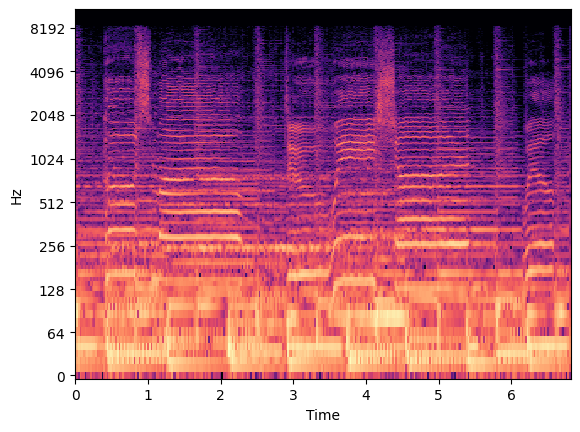

In [ ]:
import librosa
import librosa.display

STFT_WINDOW=2048
STFT_STRIDE=1024

sample = track.audio.T
sr = track.rate

X = librosa.stft(librosa.to_mono(sample), n_fft=STFT_WINDOW, win_length=STFT_WINDOW, hop_length=STFT_STRIDE)
print(X.shape)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(X), ref=np.max), y_axis='log', x_axis='time')


## Generate Training/Split Datasets

**Create Spectogram Transform**

In [ ]:
import torch.nn as nn
import torchaudio

class SpecTransform(nn.Module):
    """
    This module takes
    """

    def __init__(self, sr=16000, n_fft=2048):
        super().__init__()
        self.n_fft=n_fft
        self.sr=sr

        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=self.sr, n_fft=self.n_fft, n_mels=512)

    def forward(self, x):
        with torch.no_grad():
            return(self.mel(x))


**Create MUSDB18 Torch Dataset Class**

In [ ]:
import torch.utils
import torch
import torch.utils.data
from torchaudio.transforms import Resample
import musdb
import random

class MUSDBDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            subset='train',
            split='train',
            target='vocals',
            seq_duration=None,
            n_fft=2048,
            sr=44100
    ):
        """MUSDB18 Dataset wrapper.
        args:
        subset: one of 'test', 'train'
        split: one of 'test', 'train
        seq_duration: duration in seconds: float
        """

        self.seq_duration = seq_duration
        self.mus = musdb.DB(
            download=True,
            split=split,
            subsets=subset,
        )
        self.target=target
        self.sr=sr
        self.spec=SpecTransform(n_fft=n_fft)
        self.resample=Resample(new_freq=self.sr)

    def __getitem__(self, index):
        track = self.mus[index]
        track.chunk_start = max(0, random.uniform(0, track.duration - self.seq_duration)) # Prevents rounding errors
        track.chunk_duration = self.seq_duration
        x = track.audio.T
        y = track.targets[self.target].audio.T
        self.resample.orig_freq = track.rate
        signal_x, signal_y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        resampled_x = self.resample(signal_x)
        resampled_y = self.resample(signal_y)
        return self.spec(resampled_x), self.spec(resampled_y)

    def __len__(self):
        return len(self.mus)


In [ ]:
BATCH_SIZE = 8
mus_train = MUSDBDataset(seq_duration=7.0)
mus_test = MUSDBDataset(subset='train', split='test', seq_duration=7.0)


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


# Create PyTorch Model

# Openunmix (Audio Separation)

In [ ]:
from torch.utils.data import DataLoader
from torcheval.metrics import R2Score
from tqdm import tqdm

def test_r2(model, device, data_loader):
  """
  Test function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    data_loader: torch.loader
      Test Set

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  metric = R2Score(device=device)
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    metric.update(outputs.flatten(), labels.flatten())
  r2 = metric.compute()
  return r2

def umx_train_loop(model,
                   device,
                   checkpoint_path,
                   train_dataset,
                   epochs=10,
                   batch_size=8,
                   seed=0):
  """
  Training function

  Args:
    model: nn.module
    device: string
    checkpoint_path: string
    train_dataset: torch.loader
    epochs: int
    batch_size: int
    seed: int

  Returns:
    array of loss and accuracy
  Uses RMSE and Adam
  """
  model.to(device)
  model.train()
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  loss_fn = nn.MSELoss()
  optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.02)
  mse_loss = torch.zeros(epochs * len(train_dataset) // batch_size, device=device)
  i = 0

  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(
          output,
          target=target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)
        mse_loss[i] = loss.detach()
  return mse_loss



In [ ]:
from openunmix.model import OpenUnmix

In [ ]:
#print(OpenUnmix())

data_shape = [2, 512, 294]
umx = OpenUnmix(nb_bins=512)
if os.path.exists(f'{SAVE_PATH}/umx_weights'):
  umx = torch.load(f'{SAVE_PATH}/umx_weights')
for _ in range(2):
  umx_losses = umx_train_loop(umx, device=DEVICE, checkpoint_path=SAVE_PATH, train_dataset=mus_train, epochs=8)
  print(f'R2: {test_r2(umx, DEVICE, DataLoader(mus_test, batch_size=BATCH_SIZE))}')
  torch.save(umx, f'{SAVE_PATH}/umx_weights')



100%|██████████| 10/10 [00:44<00:00,  4.48s/batch, loss=1.34e+3]


R2: 0.9024890661239624


100%|██████████| 10/10 [00:44<00:00,  4.43s/batch, loss=1.34e+3]


R2: 0.8933937549591064


In [ ]:
from torchsummary import summary
data_shape = (2, 512, 294)

summary(umx, data_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 524,288
├─BatchNorm1d: 1-2                       [-1, 512]                 1,024
├─LSTM: 1-3                              [-1, 2, 512]              4,730,880
├─Linear: 1-4                            [-1, 512]                 524,288
├─BatchNorm1d: 1-5                       [-1, 512]                 1,024
├─Linear: 1-6                            [-1, 1024]                524,288
├─BatchNorm1d: 1-7                       [-1, 1024]                2,048
Total params: 6,307,840
Trainable params: 6,307,840
Non-trainable params: 0
Total mult-adds (M): 6.29
Input size (MB): 1.15
Forward/backward pass size (MB): 0.04
Params size (MB): 24.06
Estimated Total Size (MB): 25.25


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 524,288
├─BatchNorm1d: 1-2                       [-1, 512]                 1,024
├─LSTM: 1-3                              [-1, 2, 512]              4,730,880
├─Linear: 1-4                            [-1, 512]                 524,288
├─BatchNorm1d: 1-5                       [-1, 512]                 1,024
├─Linear: 1-6                            [-1, 1024]                524,288
├─BatchNorm1d: 1-7                       [-1, 1024]                2,048
Total params: 6,307,840
Trainable params: 6,307,840
Non-trainable params: 0
Total mult-adds (M): 6.29
Input size (MB): 1.15
Forward/backward pass size (MB): 0.04
Params size (MB): 24.06
Estimated Total Size (MB): 25.25

X left channel


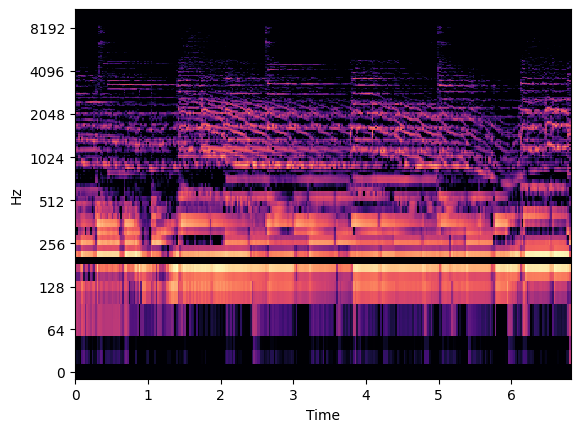

In [ ]:
print("X left channel")
x, y = mus_test[0]
librosa.display.specshow(librosa.amplitude_to_db(np.abs(x[0]), ref=np.max), y_axis='log', x_axis='time')

Y left channel


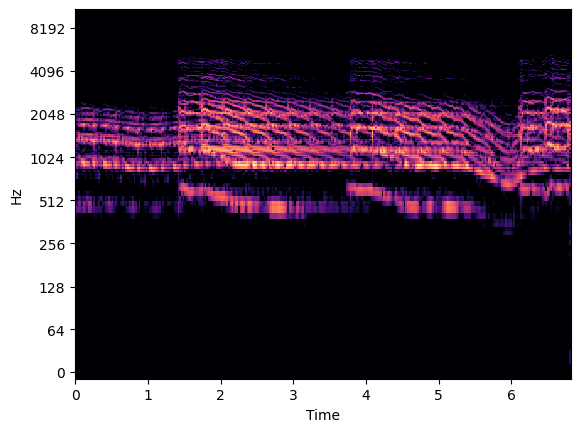

In [ ]:
print("Y left channel")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y[0]), ref=np.max), y_axis='log', x_axis='time')

Predicted Y left channel


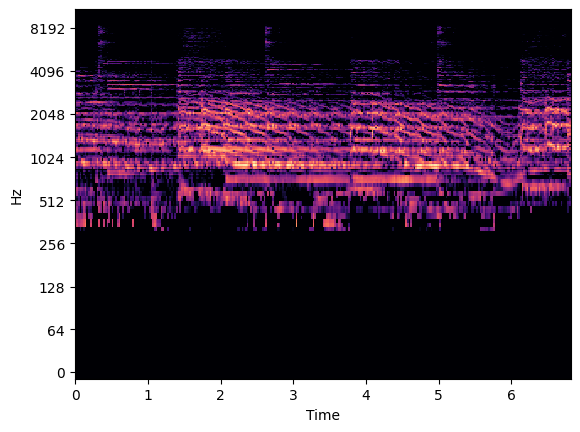

In [ ]:
print("Predicted Y left channel")

x = mus_test[0][0].unsqueeze(0).to(DEVICE)
y_pred = umx(x.to(DEVICE)).squeeze().detach().cpu()
np_spec_pred = torch.Tensor.numpy(y_pred)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(np_spec_pred[0]), ref=np.max), y_axis='log', x_axis='time')

# Music Genre Classification on the GTZAN Dataset

## Getting the GTZAN Dataset
Please make sure you have an API Key at hand if you're using Kaggle.

In [ ]:
import requests
import os

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()


GTZAN Dataset Wrapper

In [ ]:
import glob
import re

files = glob.glob('Data/genres_original' + '/**/*.wav', recursive=True)
print(files)

files_dict = dict()
for file in files:
  regexp = re.match('Data/genres_original/(.*.)/.*.\.wav', file)
  files_dict[file] = regexp.group(1)
print(files_dict)

['Data/genres_original/pop/pop.00023.wav', 'Data/genres_original/pop/pop.00003.wav', 'Data/genres_original/pop/pop.00051.wav', 'Data/genres_original/pop/pop.00070.wav', 'Data/genres_original/pop/pop.00079.wav', 'Data/genres_original/pop/pop.00053.wav', 'Data/genres_original/pop/pop.00057.wav', 'Data/genres_original/pop/pop.00020.wav', 'Data/genres_original/pop/pop.00091.wav', 'Data/genres_original/pop/pop.00004.wav', 'Data/genres_original/pop/pop.00009.wav', 'Data/genres_original/pop/pop.00074.wav', 'Data/genres_original/pop/pop.00095.wav', 'Data/genres_original/pop/pop.00050.wav', 'Data/genres_original/pop/pop.00025.wav', 'Data/genres_original/pop/pop.00034.wav', 'Data/genres_original/pop/pop.00002.wav', 'Data/genres_original/pop/pop.00061.wav', 'Data/genres_original/pop/pop.00065.wav', 'Data/genres_original/pop/pop.00029.wav', 'Data/genres_original/pop/pop.00071.wav', 'Data/genres_original/pop/pop.00059.wav', 'Data/genres_original/pop/pop.00052.wav', 'Data/genres_original/pop/pop.000

In [ ]:
import torch.utils
import torch
import torch.utils.data
import torchaudio
from torchaudio.transforms import Resample
import torch.nn.functional as F
import random
import re
import glob
import os

class GTZANDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            path,
            seq_duration=None,
            n_fft=2048,
            sr=44100,
            preprocessor=None
    ):
      """GTZAN Dataset wrapper.
      args:
      path: file directory where samples are labeled by genre
      seq_duration: duration in seconds: float
      """
      super().__init__()
      self.seq_duration = seq_duration
      self.files = self._retrieve_paths(path)
      self.sr=sr
      self.spec=SpecTransform(n_fft=n_fft)
      self.resample=Resample(new_freq=self.sr)
      self.preprocessor = preprocessor

    def _retrieve_paths(self, path):
      """
      Retrieves all matching files in path with GTZAN specification.
      It returns a dict {path: label}
      """
      assert os.stat(path) is not False

      files_list = []
      i = 0
      for file in glob.glob(f'{path}/**/*.wav', recursive=True):
        regexp = re.match(f'{path}/(.*.)/.*.\.wav', file)
        files_list.append({'index': i, 'path' : file, 'genre' : regexp.group(1) })
        i += 1

      genres = set()
      for file in files_list:
        genres.add(file['genre'])

      self.genres = {genre : i for i, genre in enumerate(genres)}

      return files_list

    def __getitem__(self, index):
      item = self.files[index]
      track, sr = torchaudio.load(item['path'])
      track_duration = track.shape[1] / sr

      if self.seq_duration is None:
        self.seq_duration = track_duration

      chunk_start = max(0, random.uniform(0, track_duration - self.seq_duration)) # Prevents rounding errors
      track = track[0][int(chunk_start * sr) : int((chunk_start + self.seq_duration) * sr)]
      x = torch.cat((track, track), dim=0)

      y = item['genre']
      self.resample.orig_freq = sr
      resampled_x = self.resample(torch.Tensor(x))
      spec_x = self.spec(resampled_x)

      if self.preprocessor is not None:
        spec_x = self.preprocessor(spec_x.to(DEVICE)).cpu()

      return self._transform_resnet(spec_x), self.genres[y]


    def _transform_resnet(self, x):
      """
    Takes stereo spectogram and adds a third averaged channel to be compatible
    for resnet.
    """
      out = torch.cat((x, x[0].unsqueeze(0)), dim=0)
      res_img = F.interpolate(out.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
      return res_img

    def __len__(self):
      return len(self.files)

**Preprocessing with OpenUnmix**

In [ ]:
umx.eval()
def preprocess_umx(x):
  """
  Takes mono channel spectogram, concatenates it with itself and unsqueezes a
  dimension at the start. Then applies a umx preprocessing.
  """
  umx.eval()
  input = torch.cat((x.unsqueeze(0), x.unsqueeze(0)), dim=0).unsqueeze(0)
  out = umx(input)

  return out.squeeze()


Create the dataset

In [ ]:

gtzan = GTZANDataset('Data/genres_original',
                     seq_duration=7,
                     preprocessor=preprocess_umx)

print(f'Size of Dataset {len(gtzan)}')

Size of Dataset 999


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


Vocal Sample from preprocessed audio in corresponding scaling

Mel Spectogram
{'pop': 0, 'hiphop': 1, 'rock': 2, 'jazz': 3, 'disco': 4, 'metal': 5, 'blues': 6, 'country': 7, 'reggae': 8, 'classical': 9}
torch.Size([3, 224, 224])


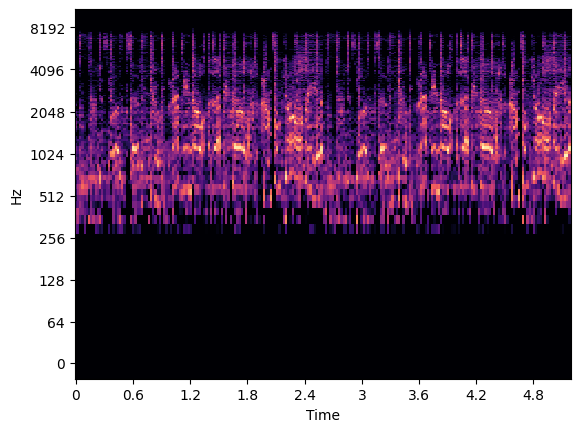

In [ ]:
from torch.utils.data import DataLoader
print("Mel Spectogram")
data = gtzan[0]
print(gtzan.genres)
print(data[0].shape)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(data[0][0].detach().numpy()), ref=np.max), y_axis='log', x_axis='time')

## Importing ResNet-50

In [ ]:
resnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
resnet.eval().to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
summary(resnet, (3, 224, 224))
print(resnet)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 2048, 7, 7]          --
|    └─Sequential: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-2                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

**Adding Softmax layer at the end.**

- Freeze ResNet
- Change Linear Shape

In [ ]:
num_genres = 10

num_ftrs = resnet.fc.out_features

resnet.fc2 = nn.Linear(num_ftrs, num_genres)

resnet.eval()

print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

### Training loop for the classifier.

In [ ]:
# resnet training loop

def resnet_train(model, device, train_loader, validation_loader, epochs):
  model.to(device)
  model.train()  # Set the entire model to training mode
  optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.0005)
  criterion = nn.CrossEntropyLoss()

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      # Training Phase
      model.fc2.train()  # Ensure model is in training mode at the start of each epoch
      print("Model in training mode:", model.training)  # Check if the entire model is in training mode
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      train_loss.append(running_loss / len(train_loader))
      train_acc.append(correct / total)

      # Validation Phase
      model.eval()  # Set model to evaluation mode for validation
      print("Model in eval mode:", not model.training)  # Check if the entire model is in eval mode
      running_loss = 0.
      correct, total = 0, 0

      with torch.no_grad():  # No need to calculate gradients during validation
        for data, target in validation_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output, target)
          tepochs.set_postfix(loss=loss.item())
          running_loss += loss.item()

          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

      validation_loss.append(running_loss / len(validation_loader))
      validation_acc.append(correct / total)

  return train_loss, train_acc, validation_loss, validation_acc

In [ ]:
# EMPTY Cache

torch.cuda.empty_cache()

In [ ]:
# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir(f'{SAVE_PATH}/checkpoint'):
      os.mkdir(f'{SAVE_PATH}/checkpoint')
  torch.save(state, f'{SAVE_PATH}/checkpoint/{outModelName}.t7')


In [ ]:
from torch.utils.data import DataLoader
gztan_train = DataLoader(gtzan, batch_size=8, shuffle=True,)
train_set, test_set = torch.utils.data.random_split(gtzan, [799, 200])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True)

In [ ]:
with torch.backends.cudnn.flags(enabled=False):
  data_shape = [3, 224, 224]
  for _ in range(10):
    resnet.fc2.train()
    resnet_losses = resnet_train(
      resnet, device=DEVICE,
      train_loader=train_loader,
      validation_loader=test_loader,
      epochs=20)
    torch.save(resnet, f'{SAVE_PATH}/checkpoint/resnet.t7')

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Model in training mode: True
Model in eval mode: True


Training:   5%|▌         | 1/20 [16:57<5:22:09, 1017.32s/epoch, loss=6.03]

Model in training mode: False


In [ ]:
%debug

> /usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py(768)_engine_run_backward()
    766         unregister_hooks = _register_logging_hooks_on_whole_graph(t_outputs)
    767     try:
--> 768         return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    769             t_outputs, *args, **kwargs
    770         )  # Calls into the C++ engine to run the backward pass

ipdb> 700
700



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
